In [1]:
from coagulation_model.coagulation_kernel import CoagulationKernel as kernel
from coagulation_model.plotting_kernels import plot_kernel_map
from coagulation_model.plotting_kernels import plot_normalized_kernel_map
from coagulation_model.plotting_kernels import plot_kernel_diff_map

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_context('notebook')

In [5]:

# Assume vcon_r is an array like [1,2,4,8,16]
vcon_r = np.array([1, 2, 4, 8, 16])

# Assuming n_sections is defined, for example
n_sections = 3

# Create vcon_mat by replicating vcon_r n_sections times
vcon_mat = np.tile(vcon_r, (n_sections, 1))

# Create vcon_shift by appending a column of zeros to the left of vcon_mat (excluding the last column)
vcon_shift = np.hstack((np.zeros((n_sections, 1)), vcon_mat[:, :-1]))

# Print the shapes of the objects
print("Shape of vcon_mat:", vcon_mat.shape)
print("Shape of vcon_shift:", vcon_shift.shape)

vcon_shift

Shape of vcon_mat: (3, 5)
Shape of vcon_shift: (3, 5)


array([[0., 1., 2., 4., 8.],
       [0., 1., 2., 4., 8.],
       [0., 1., 2., 4., 8.]])

In [2]:
def power_law(x, a, b):
    return a * x**b


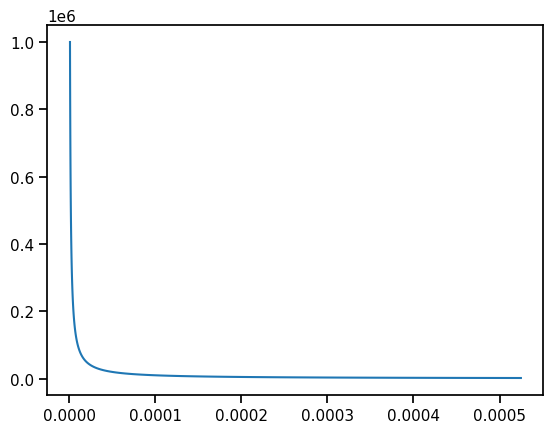

In [3]:
# plot power law from 1e-6 to 1e-3m

x = np.logspace(-6, -3.28, 100)
y = power_law(x, 1, -1)

plt.plot(x, y)


# double integral of power law
$$ I = \int_{x_{min}}^{x_{max}} \int_{y_{min}}^{y_{max}} \beta(x,y) \alpha x^{\beta} \alpha x^{\beta} dx dy $$

$$ \; =  \alpha \int_{x_{min}}^{x_{max}} \int_{y_{min}}^{y_{max}} \beta(x,y) (xy)^{\beta} dx dy $$

assuming $(x_{min},x_{max}) = (y_{min},y_{max})$, we simplify to


$$ I =  \alpha \int \int_{x_{min}}^{x_{max}}\beta(x,y) (xy)^{\beta} dx dy $$

where $\beta(x,y)$ is a the kernel of choice and  $x$ and $y$ are the respective radii.

## calculate coagulation properbility based on size classes

In [48]:
number_size_classes = 100

radius_sphere_min = 1e-6
radius_sphere_max = 1e-3

radius_boundary_spheres = np.logspace(np.log10(radius_sphere_min), np.log10(radius_sphere_max), number_size_classes+1)
# radius_mean_spheres = 


In [50]:
# normalizsation term

def integrand(x):
    return 1*x**-3

# single variable integration
from scipy.integrate import quad
results,error = quad(integrand, 1e-6, 1e-3)

results*2e-12

0.9999989999999996

In [54]:
coagulation_kernel = kernel(
    list_of_applied_kernels=[
        'rectilinear_shear',
        'rectilinear_differential_sedimentation'],
    settling_function='settling_velocity_kriest_porous_aggregate'
    )


def integrand(x, y, a=2e-12, k=3): # Note: the order of arguments is y, x due to the way dblquad expects them.
    return a*x**-k * a*y**-k * coagulation_kernel.evaluate_kernel(x,y)

results_porous, error = np.zeros(number_size_classes - 1), np.zeros(number_size_classes - 1)
for ii in range(len(results_porous)):
    # print(x0,x1)
    x0, x1 = radius_boundary_spheres[ii], radius_boundary_spheres[ii+1]
    
    results_porous[ii], error[ii] =  dblquad(integrand, x0, x1, x0,  x1)

results

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [46]:
coagulation_kernel = kernel(
    list_of_applied_kernels=[
        'rectilinear_shear',
        'rectilinear_differential_sedimentation'],
    settling_function='settling_velocity_jackson_lochmann_fractal'
    )


def integrand(x, y, a=2e-12, k=3): # Note: the order of arguments is y, x due to the way dblquad expects them.
    return a*x**-k * a*y**-k * coagulation_kernel.evaluate_kernel(x,y)

results_jackson, error = np.zeros(number_size_classes - 1), np.zeros(number_size_classes - 1)
for ii in range(len(results)):
    # print(x0,x1)
    x0, x1 = radius_boundary_spheres[ii], radius_boundary_spheres[ii+1]
    
    results_jackson[ii], error[ii] =  dblquad(integrand, x0, x1, x0,  x1)



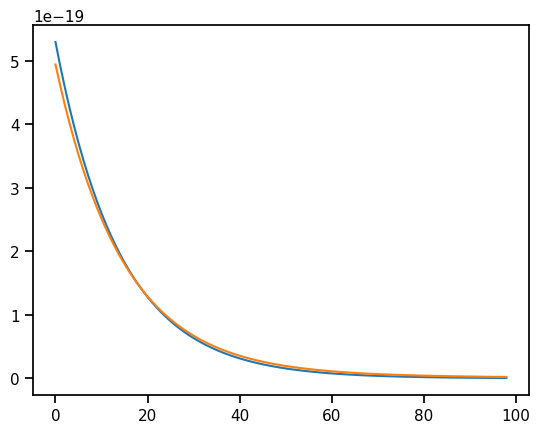

In [47]:
plt.plot(results_porous)
plt.plot(results_jackson)

### sectional coagulation kernels

In [41]:
class sectional_coagulation_kernels:
    def __init__(self, coagulation_kernel, particle_size_distribution,
                 number_size_classes, radius_sphere_min, radius_sphere_max):
        
        self.coagulation_kernel = coagulation_kernel # beta(r_i, r_j)
        self.number_size_classes = number_size_classes
        self.radius_sphere_min = radius_sphere_min
        self.radius_sphere_max = radius_sphere_max
        self.radius_boundary_spheres = np.logspace(np.log10(radius_sphere_min), np.log10(radius_sphere_max), number_size_classes+1)
        self.radius_mean_spheres = np.convolve(self.radius_boundary_spheres, np.ones(2, dtype=int), 'valid') / 2

        self.particle_size_distribution = self.init_particle_size_distribution(particle_size_distribution)
        self.sectional_coagulation_kernel = np.zeros((5,number_size_classes))
        # index 0 is sum,
        # the others are sectional kernels 1 - 4


    def init_particle_size_distribution(self, particle_size_distribution):
        if particle_size_distribution == 'power_law':
            alpha = 1
            k = -3
            return alpha*self.radius_mean_spheres**k
            

    def sectional_kernel_1_integrand(self,r_i, r_j):

        vol_i = coagulation_kernel.volume_sphere(r_i)
        vol_j = coagulation_kernel.volume_sphere(r_j)

        beta = self.coagulation_kernel

        integrand = beta.eval_kernel(r_i, r_j)
        integrand = integrand * (vol_i + vol_j)/vol_i/vol_j
        
        return integrand

    
    def sectional_kernel_1_eval(self):

        radii = self.radius_boundary_spheres
        radii = coagulation_kernel.radius_fractal(coagulation_kernel.volume_sphere(radii))

        for ii in range(self.number_size_classes):

            r_lower = radii[ii]
            r_upper = radii[ii+1]

            result, error = dblquad(self.sectional_kernel_1_integrand, 
                                    r_lower, 
                                    r_upper, 
                                    lambda x: np.max(r_upper - x, r_lower),
                                    r_upper)

            self.sectional_coagulation_kernel[1,ii] = result

In [42]:
coagulation_kernel = kernel(
    list_of_applied_kernels=[
        'rectilinear_shear',
        'rectilinear_differential_sedimentation'],
    settling_function='settling_velocity_kriest_porous_aggregate'
    )

kriest_shear_n_diff = sectional_coagulation_kernels(coagulation_kernel, 'power_law', 10, 1e-6, 1e-3)

In [43]:
kriest_shear_n_diff.sectional_kernel_1_eval()

TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [30]:
number_size_classes = 10

radius_sphere_min = 1e-6
radius_sphere_max = 1e-3

radius_boundary_spheres = np.logspace(np.log10(radius_sphere_min), np.log10(radius_sphere_max), number_size_classes+1)
# radius_mean_spheres = 

radius_mean_spheres = np.convolve(radius_boundary_spheres, np.ones(2, dtype=int), 'valid') / 2

radius_mean_spheres


array([1.49763116e-06, 2.98816701e-06, 5.96217703e-06, 1.18961071e-05,
       2.37358543e-05, 4.73592555e-05, 9.44941378e-05, 1.88540592e-04,
       3.76187938e-04, 7.50593617e-04])

In [31]:
particles_in_size_bin

array([2.97704500e+17, 3.74787761e+16, 4.71829836e+15, 5.93998570e+14,
       7.47799895e+13, 9.41424290e+12, 1.18518296e+12, 1.49205695e+11,
       1.87838841e+10, 2.36475090e+09])